<a href="https://colab.research.google.com/github/Caleb-Justice/Caleb-Justice/blob/main/Stock_Analysis_on_WMT_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STOCK MARKET ANALYSIS (**WALMART**) AND PREDICTION USING LSTM

In [5]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import plot_model

<ipython-input-5-6c867bbe6387>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# Fetch stock data from Yahoo Finance
ticker = 'WMT'
data = yf.download(ticker, start="2015-01-01", end="2023-01-01")

# The necessary information about the stock data
print(data)
print(data.describe())
print(data.info())
print(data.columns)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   86.269997   86.720001   85.550003   85.900002   71.167412   
2015-01-05   85.720001   86.320000   85.510002   85.650002   70.960281   
2015-01-06   85.980003   86.750000   85.790001   86.309998   71.507095   
2015-01-07   86.779999   88.680000   86.669998   88.599998   73.404335   
2015-01-08   89.209999   90.669998   89.070000   90.470001   74.953598   
...                ...         ...         ...         ...         ...   
2022-12-23  143.050003  143.800003  142.279999  143.770004  141.610046   
2022-12-27  144.039993  144.449997  143.190002  143.809998  141.649460   
2022-12-28  143.470001  143.669998  140.910004  141.289993  139.167297   
2022-12-29  142.139999  143.020004  141.750000  142.149994  140.014374   
2022-12-30  141.559998  141.990005  140.809

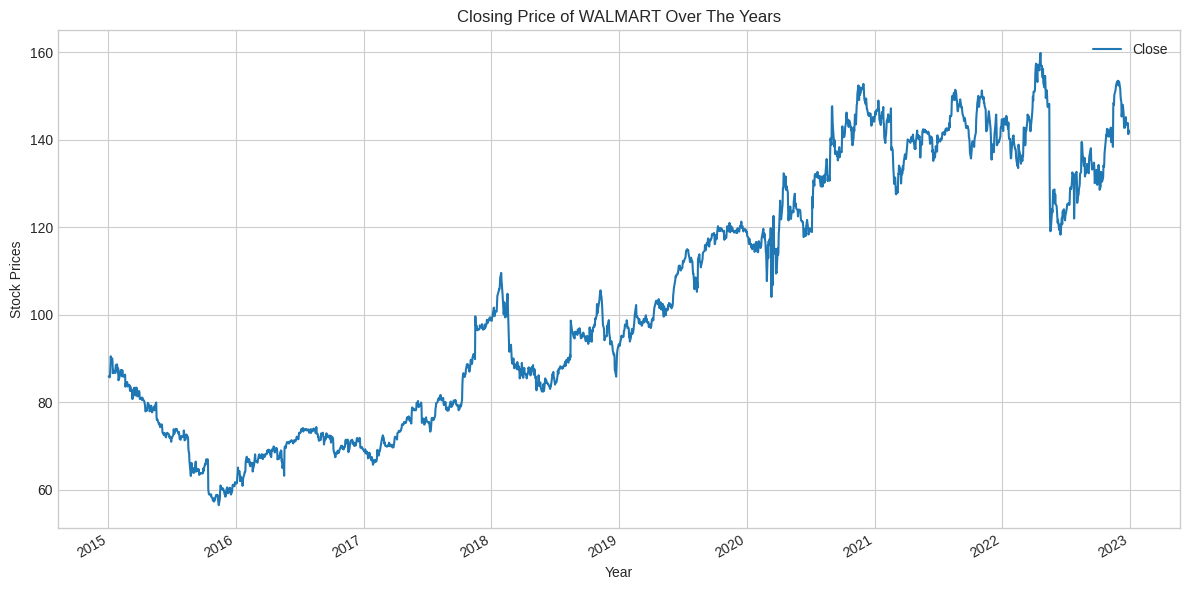

In [7]:
# Plotting the closing stock price

plt.figure(figsize=(12, 6))
data['Close'].plot()
plt.ylabel('Stock Prices')
plt.xlabel('Year')
plt.title("Closing Price of WALMART Over The Years")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Create the time series data structure
look_back = 60
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

In [9]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True,
                    input_shape=(look_back, 1)))
lstm_model.add(LSTM(units=100,return_sequences = True))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=15)

Epoch 1/15
78/78 [==============================] - 12s 15ms/step - loss: 0.0207
Epoch 2/15
78/78 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 3/15
78/78 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 4/15
78/78 [==============================] - 1s 13ms/step - loss: 0.0021
Epoch 5/15
78/78 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 6/15
78/78 [==============================] - 1s 11ms/step - loss: 0.0020
Epoch 7/15
78/78 [==============================] - 1s 11ms/step - loss: 0.0020
Epoch 8/15
78/78 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 9/15
78/78 [==============================] - 1s 10ms/step - loss: 0.0014
Epoch 10/15
78/78 [==============================] - 1s 10ms/step - loss: 0.0015
Epoch 11/15
78/78 [==============================] - 1s 13ms/step - loss: 0.0041
Epoch 12/15
78/78 [==============================] - 1s 14ms/step - loss: 0.0024
Epoch 13/15
78/78 [=================

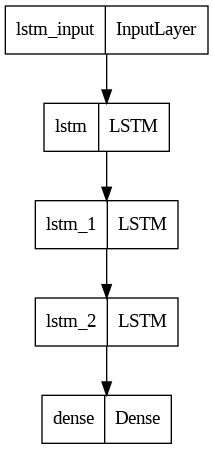

In [10]:
plot_model(lstm_model)

In [11]:
# Predicting on the test data
lstm_predictions = lstm_model.predict(test_generator)

# Invert predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(test_data[look_back:])

403/403 [==============================] - 3s 5ms/step


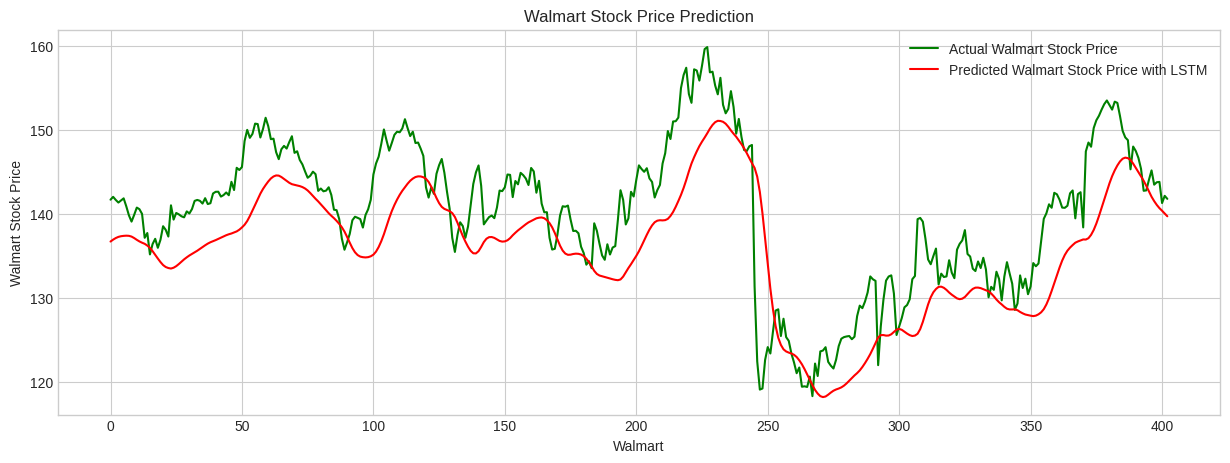

In [12]:
# Plot the data
plt.figure(figsize=(15,5))
plt.plot(actual_prices, color='green', label='Actual Walmart Stock Price')
plt.plot(lstm_predictions, color='red', label='Predicted Walmart Stock Price with LSTM')
plt.title('Walmart Stock Price Prediction')
plt.xlabel('Walmart')
plt.ylabel('Walmart Stock Price')
plt.legend()
plt.show()

In [13]:
def predict_future_days(model, base_data, days_to_predict, scaler, look_back=2000):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions



In [14]:
# Predict next 30 days
days_to_predict = 30
future_days = predict_future_days(lstm_model, scaled_data, days_to_predict, scaler, look_back)

# Print and plot the predictions for the next 5 days
print("Future predictions:", future_days)

1/1 [==============================] - 0s 34ms/step
Future predictions: [[139.38908 ]
 [138.9975  ]
 [138.53786 ]
 [138.02446 ]
 [137.47539 ]
 [136.90639 ]
 [136.329   ]
 [135.75075 ]
 [135.17607 ]
 [134.60724 ]
 [134.04524 ]
 [133.49023 ]
 [132.94208 ]
 [132.40042 ]
 [131.8649  ]
 [131.3352  ]
 [130.811   ]
 [130.29204 ]
 [129.77809 ]
 [129.26895 ]
 [128.76445 ]
 [128.26445 ]
 [127.768776]
 [127.277336]
 [126.79001 ]
 [126.306694]
 [125.82728 ]
 [125.35169 ]
 [124.87986 ]
 [124.411644]]


<ipython-input-15-5603b1e6e5fd>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')


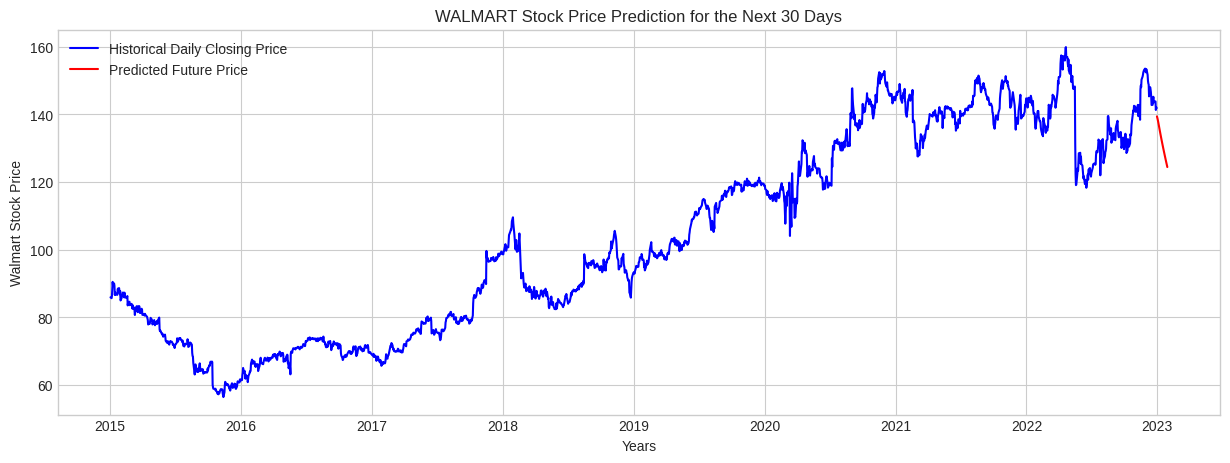

In [15]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(15,5))
plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
plt.title(f'WALMART Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Years')
plt.ylabel('Walmart Stock Price')
plt.legend()
plt.show()

In [18]:
# Out of Curiosity,
# Let's see how accurate the model was by viewing the actual data again

c_data = yf.download(ticker, start="2015-01-01", end="2023-03-01")

[*********************100%%**********************]  1 of 1 completed


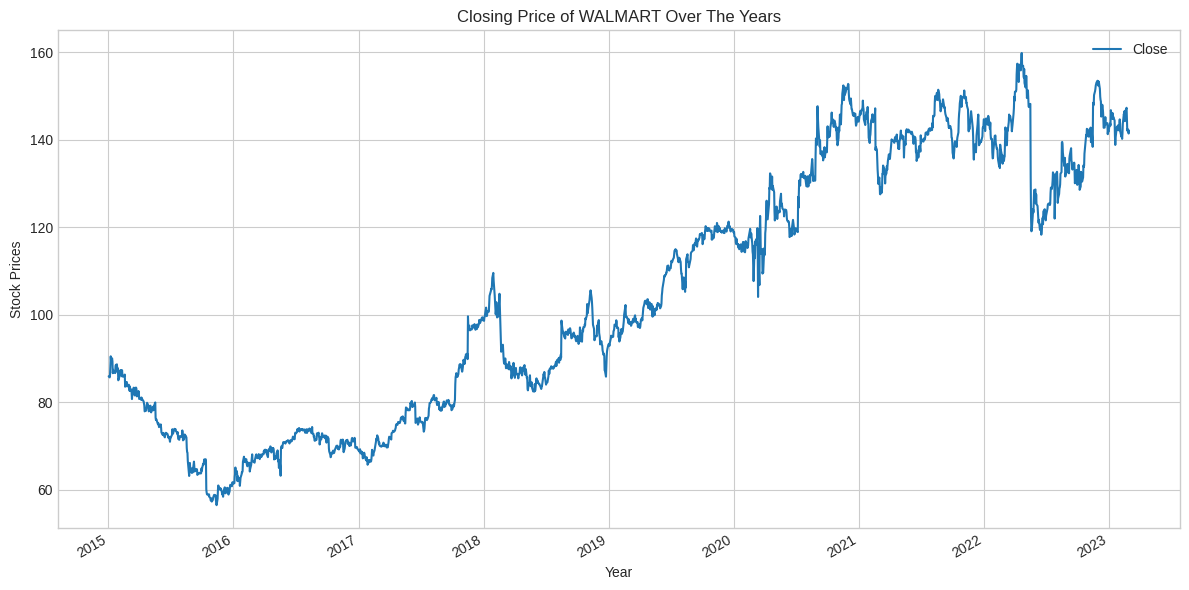

In [19]:
# Plotting the closing stock price

plt.figure(figsize=(12, 6))
c_data['Close'].plot()
plt.ylabel('Stock Prices')
plt.xlabel('Year')
plt.title("Closing Price of WALMART Over The Years")
plt.legend()
plt.tight_layout()
plt.show()